Primero ejecutar la siguiente celda con los modulos a utilizar.

In [53]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity

La idea es reemplazar los NaNs de una serie con valores de un rango de la misma serie de modo tal que la distribución luego del reemplazo sea muy parecida a la que tenía antes de los reemplazos.  
  
Para hacer esto, se utiliza la función KDE (Kernel Density Estimation) que es una técnica estadística utilizada para estimar la función de densidad de probabilidad (PDF) que es una representación suave y continua de la distribución de los datos, en contraste con los histogramas que son discretos. En resumen se busca una f(x) tal que devuelva la probabilidad de ocurrencia en un punto.


NOTA: En el caso de que la variable sea discreta la resolución es mucho mas simple ya que simplemente la probabilidad de ocurrencia de un valor es su frecuencia. Asi, en el caso de la edad, si la consideramos discretizada en años enteros simplemente se podría sacar la frecuencia **relativa** de cada valor (dist=df['Age'].value_counts(normalize=True)) y luego se generan los valores_reemplazo = np.random.choice(dist.index, size=n_NaNs, p=dist.values)

Hagamos eso primero para entender el problema.

In [54]:
# Carga del dataframe
df = pd.read_csv('titanic.csv') # Carga el dataframe

In [55]:
df.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S


In [56]:
# Esto simplemente establece como tipo entero a la variable edad.
df['Age'] = df['Age'].round().astype('Int64') 

# Se obtiene la cantidad de NaNs a reemplazar.
n_NaNs=df['Age'].isna().sum() 
n_NaNs

177

In [57]:
# Obtiene la distribución de las frecuencias de las edades (notar que ya está naturalmente discretizada bin=1 año)
dist=df['Age'].value_counts(normalize=True) # No tiene en cuenta los NaNs si tuviera dropna=False si los tendría en cuenta.

# Entonces ahora se pueden generar los valores para reemplazar NaNs
valores_reemplazo = np.random.choice(dist.index, size=n_NaNs, p=dist.values) 

Se crea una función para graficar histograma de una serie, para comparar antes y después del reemplazo.   
***Esto es simplemente para no repetir código no tiene que ver con el problema.***

In [58]:
# Grafica Histograma de una serie
def histoS(subset,col,bins=1,fsize=[8,4],color='red',kde=0):
    fig, ax = plt.subplots( figsize=(fsize[0], fsize[1]))
    sns.histplot(data=subset, x=col, bins=bins, kde=kde, ax=ax, color=color,alpha=0.3)
    ax.set_title(f'Distribución de {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Frecuencia')
    # Mostrar el gráfico
    plt.tight_layout()
    plt.show()

Se crea una serie antes y otra despues del reemplazo. *(en realidad son dataframes por comodidad)*

In [59]:
# Serie antes del reemplazo
antes=df[['Age']]
despues=df[['Age']].copy()

# Serie después del reemplazo
despues.loc[despues['Age'].isna(), 'Age'] = valores_reemplazo

# Se comprueba que no haya NaNs
despues.isna().sum()

Age    0
dtype: int64

Ahora se grafican las dos series (en realidad son dataframe por comodidad)

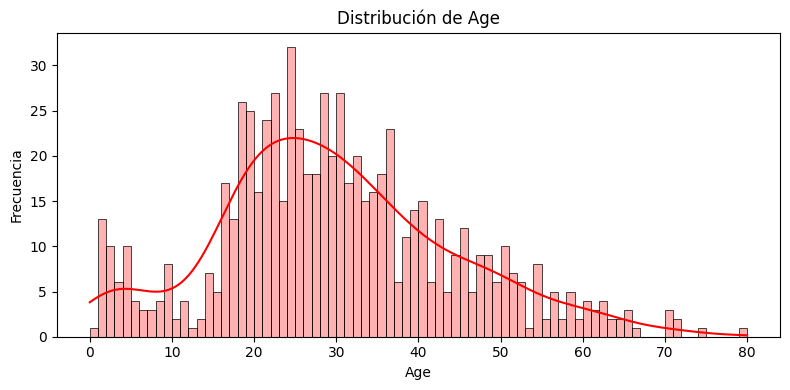

In [60]:
# Se establecen 80 bins para que el ancho sea justamente 1 año.
histoS(antes,'Age',80,[8,4],'red',1) 

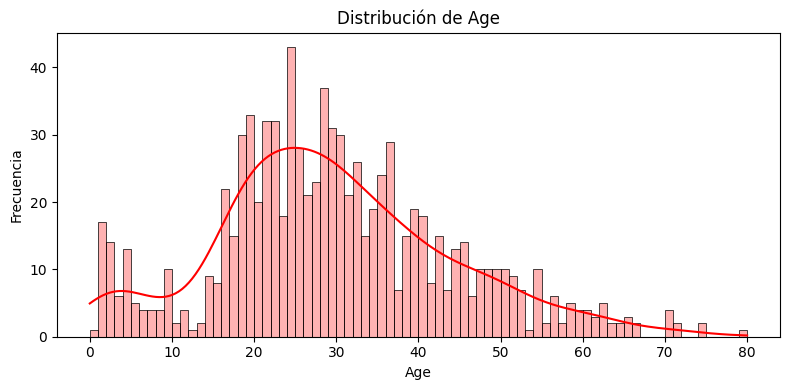

In [61]:
# Histograma de la distribución luego del reemplazo de NaNs
histoS(despues,'Age',80,[8,4],'red',1)

Como se puede observar son muy parecidos. Y para este caso discreto serviria perfectamente. Asi que todo esto podria resumirse construyendo una función que acepte una variable discreta y devuelva los valores para reemplazar.

PERO, hay algunas observaciones y críticas para hacer en el caso general:  
  
1) En la serie original hay valores de edad que faltan (por ejemplo para este caso en los 60s y los 70s). Esos valores también son posibles, pero la función que creamos no puede averigüar la probabilidad de ocurrencia de esos valores porque originalmente no están. Para solucionar esto; o bien interpolamos entre los valores más cercanos o bien ajustamos por una "curva" (KDE) que no es otra cosa que una interpolación más elaborada.  
   
2) Que pasa si la variable es continua? el propio histograma dependerá del bin elegido. Acá tambien se hace necesario una curva de ajuste para tener la probabilidad de ocurrencia en un "punto".  

En lo que sigue se intenta crear una función ,utilizando KDE, para solucionar los problemas anteriores y generalizar para cuando la variable sea continua.  
*(Hay mas comentario que código, porque sé lo feo que es leer el código de otro. (el yo del pasado cuenta como otro, :) )*

Primero se crea una función graficadora de histogramas con la posibilidad de agrupar por clase (un nivel de agrupado).   
En este caso edad agrupada por clase.('Age' groupby 'Pclass').  
*Esto es solo para graficar al último y comparar los resultados, no es parte del problema.*

In [62]:
def histog(df,col,colg,gs=0,bins=[20],ncols=1,fsize=[15,6],colores=0,kde=0):
    
    if not gs:
        gs=sorted(df[colg].unique())
    ng=len(gs)
    if len(bins)==1:
        bins=bins*ng
    nrows=-(-ng//ncols)
    if not colores:
        colores = sns.color_palette('deep')
    colores = colores* ((ng // len(colores)) + 1)
    colores=colores[:ng]

    # Crear subplots
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(fsize[0], fsize[1]))
    axes=np.ravel(axes)

    # Iterar sobre las clases y crear un histograma en cada subplot
    for i, g in enumerate(gs):
        subset = df[df[colg] == g]
        sns.histplot(data=subset, x=col, bins=bins[i], kde=kde, ax=axes[i], color=colores[i],alpha=0.3)
        axes[i].set_title(f'Distribución de {col} - {colg} {g}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frecuencia')
        axes[i].legend(labels=[f'{colg} {g}'])

    # Mostrar el gráfico
    plt.tight_layout()
    plt.show()

Aca se crea la función que dará los valores de reemplazo para casos generales.  
Básicamente KernelDensity() es la función que dará los valores según la distribución original una vez se ajuste a los datos.  
   
Mapa conceptual:  
  
1) KernelDensity() se ajusta a la distribución de los datos de entrada.
2) El ajuste de KernelDensity() depende también de un parametro llamado "ancho de banda" "bw=band width"
3) Entonces primero se utiliza GridSearchCV() (que es una especie de función iteradora que dado un modelo lo ajusta multiples veces cambiando el parametro a optimizar en cada iteración) para obtener el mejor "ancho de banda" para KernelDensity()
4) A su vez para facilitar las cosas a GridSearchCV primero se da un intervalo aproximado del ancho de banda con dos formulas probadas y conocidas como de "Silverman" y la otra "Scott".
5) Se ajusta GridSearchCV con el modelo KernelDensity() y el parámetro a optimizar o sea el ancho de banda.
6) Se obtiene el ancho de banda óptimo
7) Se ajusta KernelDensity() con ese ancho de banda óptimo y 
8) Se obtienen los valores de reemplazo utilizando el KernelDensity() ya ajustado.
  
Esta es una forma de pensar el problema, seguro hay muchas otras formas. Ademas 100% seguro de que el código se puede optimizar, corregir y generalizar más. Todavia no lo probé mucho. 

Descripción de entrada de la función:
$$rkde(Serie,minim,maxim,\text{val\_int})$$  

***Serie***: la serie de entrada original.    

***minim***: El valor minimo para los valores de reemplazo. Por defecto es el minimo de la serie.  

***maxim***: El valor maximo para los valores de reemplazo. Por defecto es el maximo de la serie.   

***val_int***: Si es 1 redondea a entero los valores de reemplazo. Por defecto devuelve los valores redondeados a entero.   

  
Salida
$$valores= [v1,v2, ··· ,vn]$$
tiene una longitud igual a la candidad de NaNs a reemplazar.

In [63]:
def rkde(sr,minim=None,maxim=None,val_int=True):
    """
    Función para crear valores para reemplazar NaNs en una serie de datos utilizando Kernel Density Estimation (KDE).

    Parámetros:
    - sr: Serie de datos con valores faltantes (NaN).
    - minim: Valor mínimo permitido en la serie (si no se proporciona, se utiliza el mínimo de la serie).
    - maxim: Valor máximo permitido en la serie (si no se proporciona, se utiliza el máximo de la serie).
    - val_interger: Si es True, los valores generados se redondean a números enteros.

    Retorna:
    Lista de valores generados para reemplazar los NaNs en la serie original.
    """

    # grid.fit admite como entrada siempre solamente un array bidimensional porque sklearn esta preparado matricialmente.
    # En este caso .reshape(-1,1) le agrega una dimension al array unidimensional
    # Ejemplo pasa de [1,2,3,4,5] a esto [[1],[2],[3],[4],[5]] ya que en este caso es una sola variable. 
    # Se sacan de la serie original los NaNs 
    srd=sr.dropna().values.reshape(-1, 1)
    
    # Cálculo del número de NaNs (para saber cuantos valores se necesitan) y el mínimo y máximo de la serie.
    nv=sr.isna().sum() # nv numero de valores
    if not minim:
        minim=srd.min() # Si no se dá un minimo, por defecto es el mínimo de la serie.
    if not maxim:
        maxim=srd.max() # Si no se dá un máximo, por defecto es el máximo de la serie.

    # Se necesita saber el ancho de banda óptimo para KDE (no confundir con bins) tiene que ver con cuán suave es la curva de ajuste.
        
    # Regla de Silverman para obtener una estimación inicial del ancho de banda óptimo
    silverman_bandwidth = 0.9 * min(np.std(srd), np.percentile(srd, 75) - np.percentile(srd, 25)) * len(srd)**(-1/5)

    # Regla de Scott para obtener otra estimación inicial del ancho de banda óptimo
    scott_bandwidth = (4 * np.std(srd)**5 / (3 * len(srd)))**(1/5)

    # Definir intervalos basados en las estimaciones de Silverman y Scott se elijen los mas extremos y se le da un margen
    # de seguridad 2.
    lower_bound = min(silverman_bandwidth, scott_bandwidth) / 2
    upper_bound = max(silverman_bandwidth, scott_bandwidth) * 2

    # Definir el espacio de búsqueda de valores de ancho de banda
    # Aca se establece el intervalo divido en 20 partes, en donde se ira probando por iteracion que ancho de banda es el óptimo.
    bws = np.logspace(np.log10(lower_bound), np.log10(upper_bound), 20)

    # Configurar la validación cruzada. Esto es para averiguar que ancho de banda es el que ajusta mejor KDE a los datos
    # de la serie sin los NaNs.
    # GridDearchCV toma el modelo KernelDensity y los anchos de banda posibles bws (son 20) e itera y ve con cual da mejor
    # resultado y mas abajo hace fit, y obtiene el mejor ancho de banda (best_bw)
    grid = GridSearchCV(KernelDensity(), {'bandwidth': bws}, cv=5) # aca se pasa el modelo y el parámetro a optimizar en este caso bw
    grid.fit(srd) # Resuelve y ajusta para cada bw en bws la serie con el modelo KernelDensity partiendo en cv=5 el la serie utilizando
    # 4 partes para entrenamiento y 1 para prueba. Esto lo repite y veces rotando la muestra de prueba y promediando para cada bw.

    # Obtener el mejor valor de bw
    best_bw = grid.best_params_['bandwidth']

    # Crear una nueva instancia de KDE con el mejor bw
    kde = KernelDensity(bandwidth=best_bw)

    # Ajustar el modelo a los datos sin NaN
    kde.fit(srd) # Aqui ajusta el KDE a srd (serie sin nans).

    # Inicializa array de los valores aleatorios de reemplazo y el índice del while
    valores = []
    i = 0

    # Genera valores aleatorios hasta que todos estén dentro del rango ya que kde genera valores entre -infinito y +infinito
    # y lo que se quiere es valores en un intervalo dado.
    while len(valores) < nv:        # Mientras no se haya completado el numero necesario de valores para reemplazar los NaNs sigue.
        vs = kde.sample(nv)[0]      # Aqui da nv valores segun KDE 
        vs = vs[(vs >= minim) & (vs <= maxim)] # Aqui los "recorta" para que queden solos los comprendidos en el intervalo establecido.
        valores.extend(vs) # Aqui los agrega 
        i += 1

    # Luego de salir del while es posible sea mas largo que nv asi que recorta la lista para que coincida con la cantidad 
    # necesaria para reemplazar los NaNs.
    valores = valores[:nv]

    # Si val_int es True devuelve enteros.(por defecto lo es)    
    if val_int:
        valores=[int(round(x)) for x in valores] # Redondea a enteros los valores.


    return valores

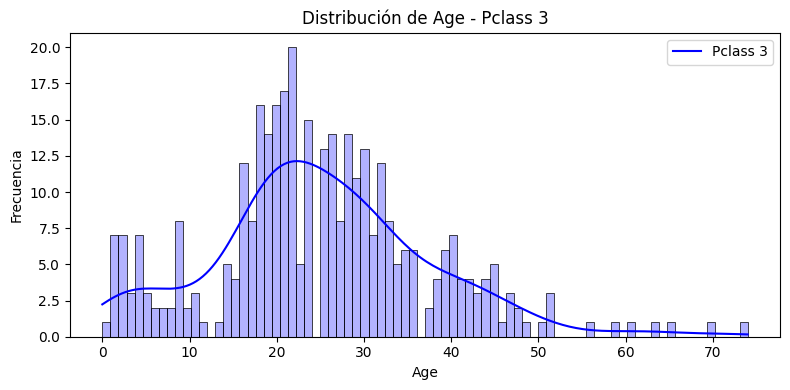

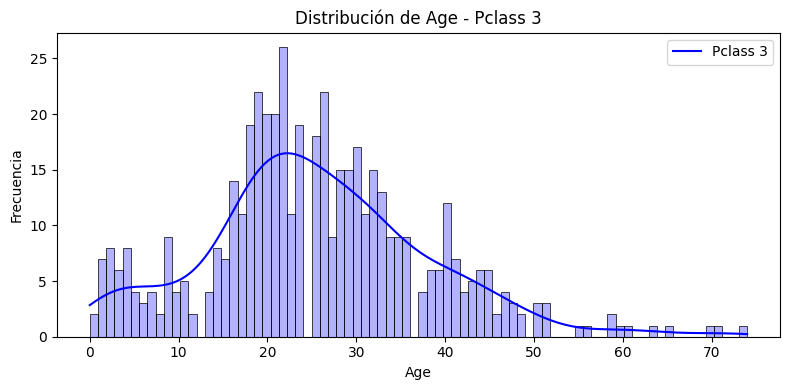

In [64]:
# Histograma antes de reemplazar NaNs
histog(df,'Age','Pclass',[3],[80],1,[8,4],['blue','orange','green'],1)

# Serie de entrada original. En este caso analizamos edades de clase 3
cond=df['Pclass'] == 3
antes=df[cond]['Age']  

# Calculo valores de reemplazo. 0,80 es el intervalo de edades que se esperan podria ponerse tambien 0,100.
# Si no pusieramos 0 como la funcion kde tiene dominio infinito podriamos tener valores negativos 
# pero las edades no pueden ser negativas
val=rkde(antes,0,80)

# Establezco nueva serie para despues de los reemplazos
despues=df.copy()
# Reemplazo NaNs por valores
despues.loc[(despues['Pclass'] == 3) & (despues['Age'].isna()), 'Age'] = val

# Grafico histograma despues de los reemplazos
histog(despues,'Age','Pclass',[3],[80],1,[8,4],['blue','orange','green'],1)


Notar:
1) La distribución después del reemplazo además de ser muy parecida a la original, tiene valores en donde la original NO tiene. Es decir ahora pueden ocurrir todos los valores en el intervalo de edades [0,80] con su respectiva probabilidad segun la distribución original aunque en ella no se hayan registrado.(ver bien en cada corrida son diferentes los valores de reemplazo)  
2) Quedaría probar para el caso de variable continua como se comporta.

In [65]:
despues[despues['Pclass']==3]['Age'].isna().sum() # Corroboro que para las edades de clase 3 no hay NaNs

0